# Исследование причин убытков развлекательного приложения Procrastinate Pro+
<br>


**Описание данных**<br>

Нам доступны данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
 - лог сервера с данными об их посещениях,<br>
 - выгрузка их покупок за этот период,<br>
 - рекламные расходы.<br>

Нам предстоит изучить:
 - откуда приходят пользователи и какими устройствами они пользуются,
 - сколько стоит привлечение пользователей из различных рекламных каналов;
 - сколько денег приносит каждый клиент,
 - когда расходы на привлечение клиента окупаются,
 - какие факторы мешают привлечению клиентов.


**Цель исследования**<br>

Выявить причины, вызывающие убытки приложения. Это позволит пересмотреть маркетинговую политику компании и помочь выйти в плюс.<br>

**Ход исследования**<br>
1. Откроем файлы с данными и изучим общую информацию;<br> 
Проведем предобработку данных, подготовим их к анализу (поработаем с типами данных, пропусками, добавим при необходимости новые столбцы);
2. Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии;
3. Проведем исследовательский анализ данных: составим профили пользователей, классифицируем их по странам нахождения, используемым устройствам и рекламным источникам привлечения, визуализируем динамику расходом во времени и посчитаем среднюю стоимость привлечения одного пользователя из каждого источника;
4. Проанализируем затраты на маркетинг: посчитаем общую сумму расходов, их распределение по источникам;
5. Оценим окупаемость рекламы, проверим показатели конверсии и удержания пользователей;
6. Напишем общий вывод:	выделим причины неэффективности привлечения пользователей и сформулируем рекомендации для отдела маркетинга.

### Загрузим данные и подготовим их к анализу

Загрузите данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

Изучите данные и выполните предобработку. Есть ли в данных пропуски и дубликаты? Убедитесь, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратите внимание на столбцы с датой и временем.

In [1]:
# Импортируем нужные библиотеки для чтения файлов, построения графиков и проведения расчетов:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta
import numpy as np

In [2]:
# Сразу ограничим показ данных формата float до 3х символов после точки:
pd.options.display.float_format = '{:,.3f}'.format

# Загрузим файлы:
visits, orders, costs = (
    pd.read_csv('/datasets/visits_info_short.csv'),
    pd.read_csv('/datasets/orders_info_short.csv'),
    pd.read_csv('/datasets/costs_info_short.csv')
                         )

In [3]:
# Изучаем файлы по порядку, сначала визиты:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [4]:
# Посмотим 10 случайно выбранных строк датасета:
visits.sample(n=10)

,User Id,Region,Device,Channel,Session Start,Session End
193142,564058685655,United States,Mac,RocketSuperAds,2019-10-19 08:31:27,2019-10-19 08:59:02
194094,758475233315,United States,Mac,TipTop,2019-10-20 10:49:28,2019-10-20 11:26:58
204607,762656793096,United States,iPhone,TipTop,2019-10-27 04:54:43,2019-10-27 04:56:39
304131,609975349777,Germany,iPhone,LeapBob,2019-10-21 18:50:38,2019-10-21 20:08:25
178405,185791079954,United States,PC,TipTop,2019-10-08 02:47:03,2019-10-08 04:01:27
234780,68152183323,UK,PC,WahooNetBanner,2019-06-26 09:11:53,2019-06-26 09:16:14
196418,27060107743,United States,Mac,FaceBoom,2019-10-21 08:03:57,2019-10-21 08:37:44
305568,251316797568,UK,Android,AdNonSense,2019-10-23 22:07:06,2019-10-23 22:55:18
63318,152108249602,United States,iPhone,FaceBoom,2019-07-03 06:57:15,2019-07-03 07:03:22
105799,211809653757,United States,iPhone,organic,2019-08-12 21:46:39,2019-08-12 22:11:48


In [5]:
# Проверим наличие дубликатов 
visits.duplicated().sum()

0

Итак, пропуски отсутствуют, а в столбцах "Session Start" и "Session End" нужно изменить тип данных, привести к формату даты.<br>
Все названия столбцов нужно переписать в "змеином регистре".

In [6]:
# Далее изучим таблицу с заказами:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [7]:
orders.sample(n=10)

,User Id,Event Dt,Revenue
4730,980238737468,2019-06-24 18:43:22,4.990
35414,554494869625,2019-09-12 14:31:30,4.990
28959,821090955164,2019-06-03 10:34:36,4.990
39850,275341387049,2019-10-27 03:25:01,4.990
15118,395186914429,2019-08-30 19:11:09,4.990
2506,799586277515,2019-06-04 01:27:58,4.990
21699,24203076021,2019-10-02 03:11:00,4.990
28156,772883756811,2019-05-10 22:27:24,4.990
12497,25742000944,2019-08-14 02:39:12,4.990
15137,580483334794,2019-08-30 08:59:52,4.990


In [8]:
orders.duplicated().sum()

0

Пропуски отсутствуют, в столбце "Event Dt" нужно изменить тип данных, привести к формату даты.<br>
Все названия столбцов нужно переписать в "змеином регистре".

In [9]:
# Теперь таблица с расходами
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [10]:
costs.sample(n=10)

,dt,Channel,costs
986,2019-07-26,AdNonSense,15.750
775,2019-06-25,YRabbit,3.780
1534,2019-08-03,WahooNetBanner,33.000
1020,2019-08-29,AdNonSense,13.650
465,2019-08-14,RocketSuperAds,8.190
1006,2019-08-15,AdNonSense,16.800
1017,2019-08-26,AdNonSense,17.850
1563,2019-09-01,WahooNetBanner,36.000
1654,2019-06-04,lambdaMediaAds,5.600
324,2019-09-22,MediaTornado,4.320


In [11]:
costs.duplicated().sum()

0

Пропуски отсутствуют, в столбце "dt" нужно изменить тип данных, привести к формату даты.<br>
Название столбца "Channel" нужно переписать в нижнем регистре.

**Вывод после знакомства с данными**<br>
Что нужно будет сделать далее в предобработке:<br>

- Исправить нарушения стиля (не соблюден "змеиный регистр", присутствуют заглавные буквы в названиях столбцов)

- Изменить с типа object на datetime данные в столбцах, где обозначена дата:
  - файл visits - столбцы Session Start и Session End 
  - файл orders - столбец Event Dt 
  - файл costs - столбец dt
  
- Заодно поменять тип данных с float64 на float32 и int64 на int32 для экономии памяти во всех файлах.

In [12]:
# Переведем названия столбцов в нижний регистр
visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()
costs.columns = costs.columns.str.lower()

visits = visits.rename(columns={
               'user id':'user_id', 'session start':'session_start', 
               'session end':'session_end'})

orders = orders.rename(columns={'user id':'user_id', 'event dt':'event_dt'})

# Меняем тип object на datetime
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

# Оптимизируем память
visits['user_id'] = visits['user_id'].astype('int32')
orders['user_id'] = orders['user_id'].astype('int32')
orders['revenue'] = orders['revenue'].astype('float32')
costs['costs'] = costs['costs'].astype('float32')

Проверим изменения:

In [13]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int32         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int32(1), object(3)
memory usage: 13.0+ MB


In [14]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int32         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float32       
dtypes: datetime64[ns](1), float32(1), int32(1)
memory usage: 628.4 KB


In [15]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float32
dtypes: float32(1), object(2)
memory usage: 35.3+ KB


**Вывод по предобработке**<br>

- Исправлены нарушения стиля,

- В столбцах, где обозначена дата, изменен тип object на datetime данные 
 
- Изменён тип данных с float64 на float32 и int64 на int32 для экономии памяти во всех файлах.

Переходим к заданию функций для расчёта бизнес-показателей.

### Функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

**Функция для создания профилей пользователей get_profiles**

In [16]:
def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

**Функция для расчета Retention Rate get_retention**

In [17]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

**Функция для подсчёта конверсии get_convertion**

In [18]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

**Функция для подсчёта LTV и ROI**

In [19]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

**Функции для построения графиков:**

**Функция для сглаживания фрейма**

In [20]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

**Функция для построения графика Retention Rate**

In [21]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

**Функция для построения графика конверсии**

In [22]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

**Функция для визуализации LTV и ROI**

In [23]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))
    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [24]:
# Сразу установим момент и горизонт анализа данных

observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

### Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

**Создание профилей пользователей**<br>

Создадим профили пользователей с помощью функции get_profiles():

In [25]:
# Сначала исключим из расчетов файл с регистрацией событий
events = None 

profiles = get_profiles(visits, orders, events, costs)
display(profiles.head(10))

# Посчитаем количество профилей
print('количество профилей:', len(profiles))

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,-2147409877,2019-06-16 08:42:58,organic,PC,UK,2019-06-16,2019-06-01,True,0.000
1,-2147375740,2019-05-29 20:03:52,FaceBoom,Android,United States,2019-05-29,2019-05-01,False,1.114
2,-2147362870,2019-08-15 01:45:41,organic,iPhone,United States,2019-08-15,2019-08-01,False,0.000
3,-2147310616,2019-08-12 10:58:20,organic,Mac,United States,2019-08-12,2019-08-01,False,0.000
4,-2147294564,2019-05-25 13:25:52,RocketSuperAds,iPhone,United States,2019-05-25,2019-05-01,False,0.544
5,-2147273579,2019-08-20 02:31:25,TipTop,iPhone,United States,2019-08-20,2019-08-01,False,3.027
6,-2147241204,2019-06-09 07:02:20,LeapBob,Mac,France,2019-06-09,2019-06-01,False,0.210
7,-2147211470,2019-06-27 12:00:46,MediaTornado,Mac,United States,2019-06-27,2019-06-01,False,0.240
8,-2147189619,2019-05-26 00:04:49,organic,iPhone,United States,2019-05-26,2019-05-01,False,0.000
9,-2147186535,2019-05-13 10:04:40,organic,Android,United States,2019-05-13,2019-05-01,False,0.000


количество профилей: 150007


Найдем минимальную и максимальную дату привлечения пользователей:

In [64]:
print('Минимальная дата привлечения пользователей', profiles['dt'].min())
print('Максимальная дата привлечения пользователей', profiles['dt'].max())

Минимальная дата привлечения пользователей 2019-05-01
Максимальная дата привлечения пользователей 2019-10-27


Мы увидели user_id, дату и месяц первого посещения сайта, канал привлечения, устройство, регион нахождения, признак оплаты и средние расходы на привлечение одного пользователя, рассчитанные по каждой когорте.<br>

Также нашли минимальную и максимальную даты привлеченя пользователей. <br>

Всего профилей пользователей 150 007 шт. 

**Профили пользователей по странам**<br>

Рассмотрим поближе распределение по странам.

In [26]:
# Покажем список уникальных значений стран пользователей и сводную таблицу с количеством и долей платящих по странам
display(profiles.region.unique())

profiles.groupby('region').agg({'user_id': 'nunique', 'payer':'mean'}).sort_values(by='payer', ascending = False)

array(['UK', 'United States', 'France', 'Germany'], dtype=object)

,user_id,payer
region,,
United States,100002,0.069
Germany,14980,0.041
UK,17575,0.040
France,17450,0.038


Основной рынок приложения в США, в остальных исследуемых странах Европы пользователей в разы меньше.<br>
Также, в США больше доля платящих пользователей: 7%, в остальных странах 4%.

**Профили пользователей по устройствам**

In [27]:
# Покажем список уникальных значений устройств пользователей и сводную таблицу с количеством и долей платящих
display(profiles.device.unique())

profiles.groupby('device').agg({'user_id': 'nunique', 'payer':'mean'}).sort_values(by='user_id', ascending = False)

array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object)

,user_id,payer
device,,
iPhone,54479,0.062
Android,35031,0.059
PC,30455,0.050
Mac,30042,0.064


Больше всего пользователей с iPhone, доля платящих примерно равна у всех и составляет 6% (только у РС меньше - 5%).

**Профили пользователей по рекламным источникам привлечения**<br>

In [29]:
# И снова покажем список уникальных значений, а также сводную таблицу с количеством и долей платящих
display(profiles.channel.unique())

profiles.groupby('channel').agg({'user_id': 'nunique', 'payer':'mean'}).sort_values(by='payer', ascending = False)

array(['organic', 'FaceBoom', 'RocketSuperAds', 'TipTop', 'LeapBob',
       'MediaTornado', 'AdNonSense', 'OppleCreativeMedia', 'YRabbit',
       'WahooNetBanner', 'lambdaMediaAds'], dtype=object)

,user_id,payer
channel,,
FaceBoom,29144,0.12
AdNonSense,3880,0.11
lambdaMediaAds,2149,0.10
TipTop,19561,0.10
RocketSuperAds,4448,0.08
WahooNetBanner,8552,0.05
YRabbit,4312,0.04
MediaTornado,4364,0.04
LeapBob,8553,0.03


Для привлечения платящих пользователей лучше всего подходит канал FaceBoom: здесь самая большая доля платящих и второе по количеству пользователей место.

Отметим второй по количеству пользователей канал TipTop, он и по доле платящих в лидерах.

Лидер по количеству пользователей - organic, но там минимальная доля платящих, всего 2%.

**Общий вывод по исследовательскому анализу:**

 - Основной рынок приложения в США: здесь наибольшие количество пользователей и доля платящих,
 - Пользователи больше предпочитают мобильные устройства, в лидерах - iPhone,
 - Для привлечения платящих пользователей лучше всего подходит канал FaceBoom.

### Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

**Общая сумма расходов на маркетинг:**

In [67]:
print('Общая сумма расходов на маркетинг:', costs['costs'].sum(), 'у.е.')

Общая сумма расходов на маркетинг: 105497.3 у.е.


**Распределение затрат по рекламным источникам:**

In [31]:
# Построим сводную таблицу с величинами затрат и их долями в общем количестве
ads_costs = costs.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs', ascending=False)
ads_costs['%'] = round((ads_costs['costs'] / ads_costs['costs'].sum())*100, 2)
ads_costs

,costs,%
channel,,
TipTop,"54,751.30",51.90
FaceBoom,"32,445.60",30.75
WahooNetBanner,"5,151.00",4.88
AdNonSense,"3,911.25",3.71
OppleCreativeMedia,"2,151.25",2.04
RocketSuperAds,"1,833.00",1.74
LeapBob,"1,797.60",1.70
lambdaMediaAds,"1,557.60",1.48
MediaTornado,954.48,0.90


Лидеры по затратам - каналы TipTop и FaceBoom, суммарно более 80% всех расходов.<br>
Те самые, которые приводят нам многих платящих пользователей.

**Динамика изменения расходов по каналам привлечения:**

In [50]:
# По месяцам график уже есть, займемся неделями: создадим новый столбец 'dt_week' в датафрейме с расходами.
# Далее получим недели из столбца 'dt'.
costs['dt_week'] = costs['dt'].astype('datetime64[W]')

# Посмотрим, что получилось: 
costs.head(20)

,dt,channel,costs,dt_week
0,2019-05-01,FaceBoom,113.300,2019-04-25
1,2019-05-02,FaceBoom,78.100,2019-05-02
2,2019-05-03,FaceBoom,85.800,2019-05-02
3,2019-05-04,FaceBoom,136.400,2019-05-02
4,2019-05-05,FaceBoom,122.100,2019-05-02
5,2019-05-06,FaceBoom,118.800,2019-05-02
6,2019-05-07,FaceBoom,101.200,2019-05-02
7,2019-05-08,FaceBoom,100.100,2019-05-02
8,2019-05-09,FaceBoom,93.500,2019-05-09
9,2019-05-10,FaceBoom,104.500,2019-05-09


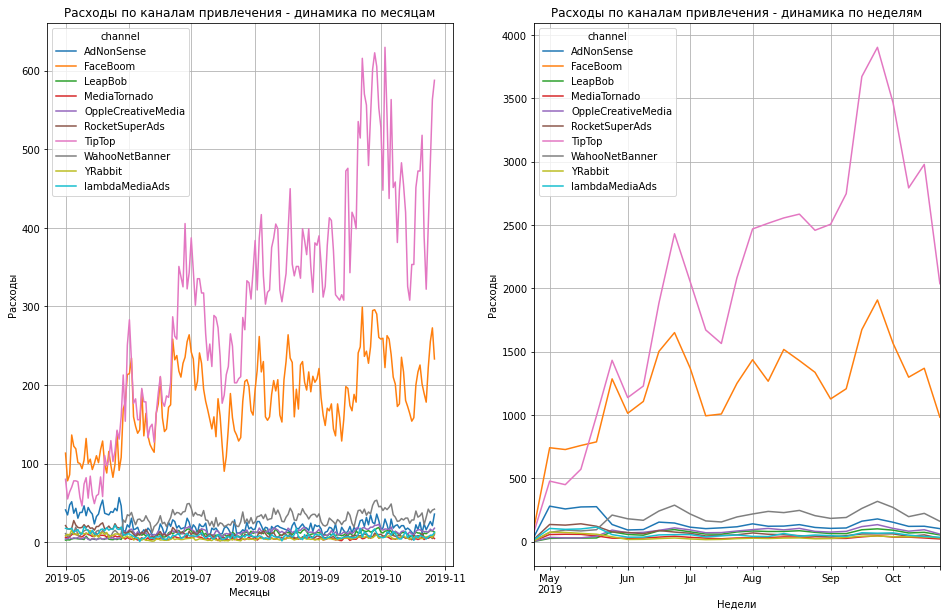

In [77]:
# Отобразим графики вместе с помощью функции subplot():

costs.pivot_table(
        index='dt', columns='channel', values='costs', aggfunc='sum'
                  ).plot(                                             
                         figsize=(16, 10),
                         grid=True,
                         legend=True,
                         ax=plt.subplot(1, 2, 1)
                         ) 
plt.title('Расходы по каналам привлечения - динамика по месяцам')
plt.xlabel('Месяцы')
plt.ylabel('Расходы')


costs.pivot_table(
        index='dt_week', columns='channel', values='costs', aggfunc='sum'
                  ).plot(                                             
                         figsize=(16, 10),
                         grid=True,
                         legend=True,
                         ax=plt.subplot(1, 2, 2)
                         ) 
plt.title('Расходы по каналам привлечения - динамика по неделям')
plt.xlabel('Недели')
plt.ylabel('Расходы')

plt.show()

Самые затратные каналы: TipTop и FaceBoom.<br>
Пик расходов пришёлся вторую половину сентября.

**Средняя стоимость привлечения одного пользователя (CAC) из каждого источника**

In [58]:
# Сначала уберём органических пользователей, так как расходы по их привлечению равны нулю, 
# и в расчетах среднего они могут исказтить результат:
profiles = profiles.query('channel != "organic"')

# Посчитаем средний CAC для каждого канала:
cac_by_channel = pd.DataFrame()
cac_by_channel['acquisition_cost_mean'] = profiles.groupby('channel')['acquisition_cost'].mean()
cac_by_channel.sort_values(by='acquisition_cost_mean', ascending=False)

,acquisition_cost_mean
channel,
TipTop,2.799
FaceBoom,1.113
AdNonSense,1.008
lambdaMediaAds,0.725
WahooNetBanner,0.602
RocketSuperAds,0.412
OppleCreativeMedia,0.250
YRabbit,0.219
MediaTornado,0.219


Самые дорогие каналы привлечения: TipTop и FaceBoom.

**Вывод по исследованию затрат на маркетинг:**


 - Общие расходы: почти 105 500 у.е. на привлечение пользователей за исследуемые полгода;
<br>

 - Самые дорогие каналы привлечения: TipTop и FaceBoom, суммарно более 80% всех расходов.<br>
При этом почти половина бюджета ушла на один источник - TipTop, и привлечённые из него покупатели обошлись дороже всего.
<br>

 - За период исследования затраты на маркетинг через TipTop выросли в 6 раз.<br>
Также, в течение всего периода исследования, виден рост расходов только на каналы TipTop и FaceBoom, затраты на остальные можно назвать неизменными.
<br>
 - Самые дорогие каналы привлечения по средней стоимости CAC: те же TipTop и FaceBoom.<br>
 Уточним, что при расчете среднего мы не учитывали канал "organic", через который затраты на привлечение пользователей отсутствуют.

### Окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

**Окупаемость рекламы**<br>

Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI

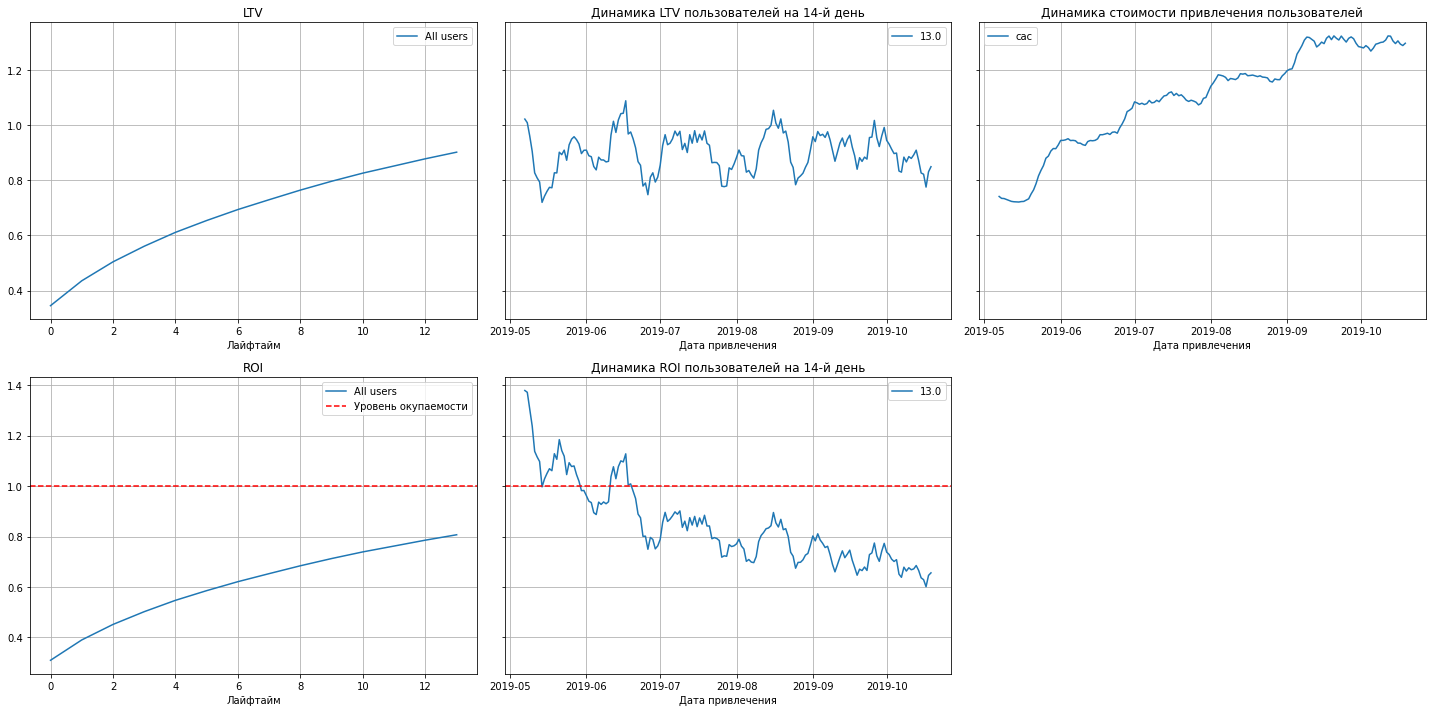

In [34]:
# Посчитаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# Построим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Показатель LTV относительно стабилен, но динамика расходов по привлечению пользователей (САС) постоянно растет.<br>
Соответственно, снижается окупаемость: в середине июня ROI опустился ниже 100% и больше не возвращался.<br>

Далее стоимость, в которую компании обходится привлечение новых клиентов, только увеличивается, а реклама не окупается.

**Конверсия и удержание пользователей**

Посмотрим в разбивках отдельно по странам, пользовательским устройствам и каналам привлечения.

**Конверсия и удержание с разбивкой по устройствам**

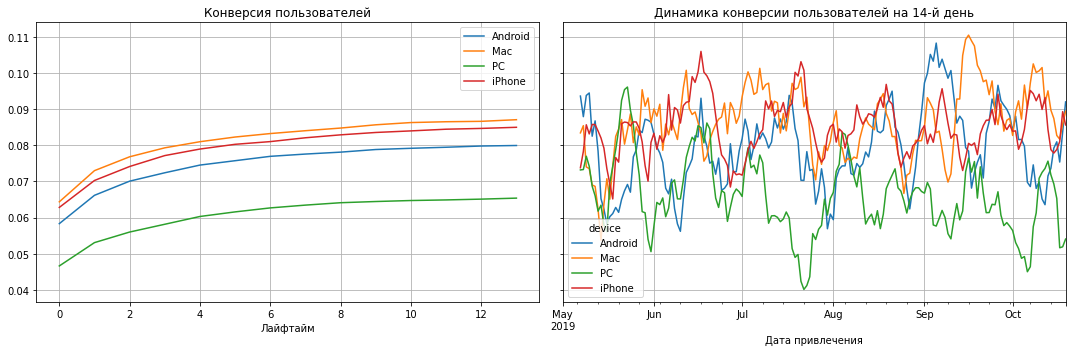

In [35]:
dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Пользователи Mac конвертируются лучше всего, следом идут iPhone и Android. <br>
Пользователи PC конвертируются хуже всех.

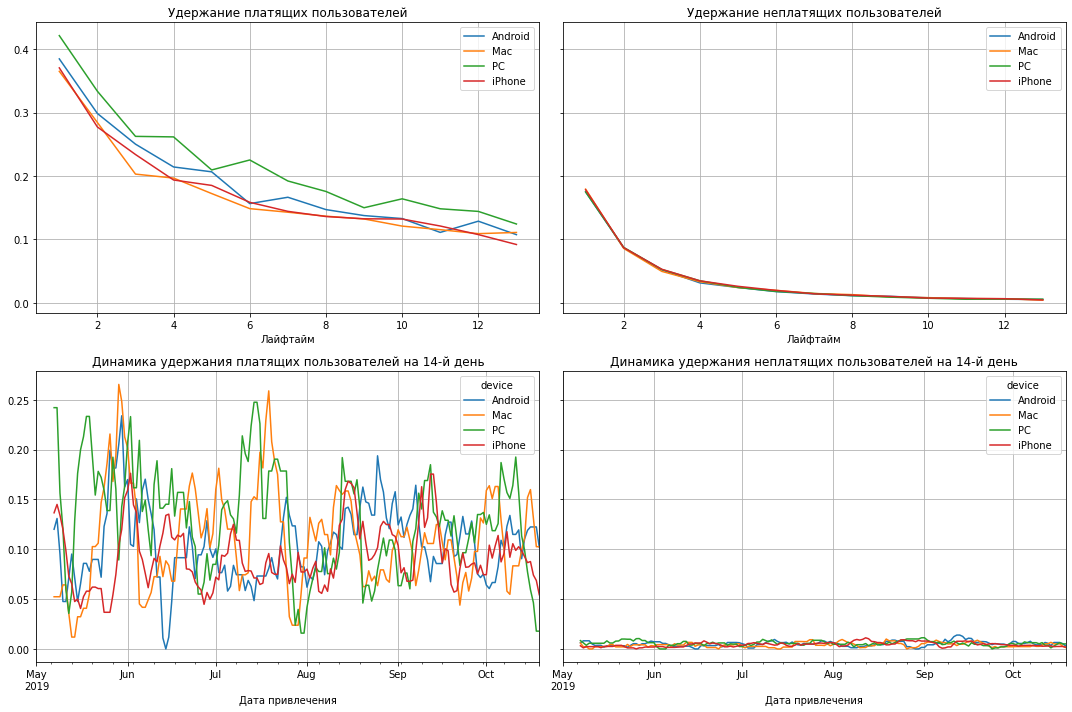

In [36]:
dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

В отличие от конверсии, удержание выше у пользователей PC, но немного.

Также отметим, что динамика удержания неплатящих пользователей примерно одинаковая на всех устройствах.

**Конверсия и удержание с разбивкой по странам**

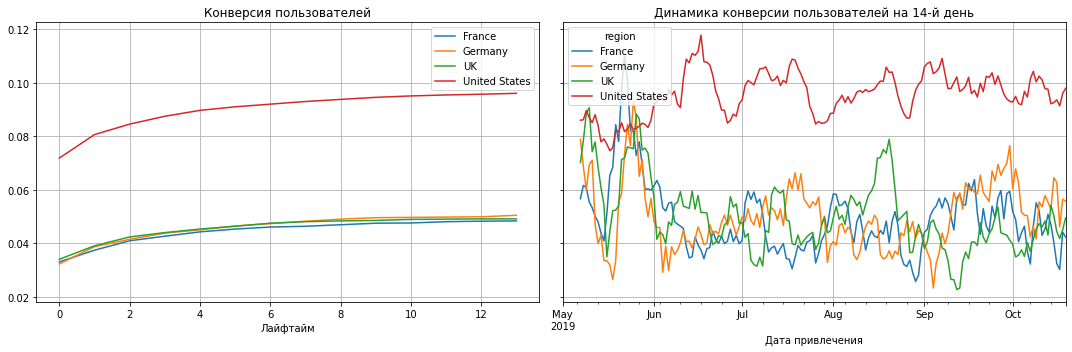

In [37]:
dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

США лидирует по конверсии пользователей, динамика тоже это подтверждает.

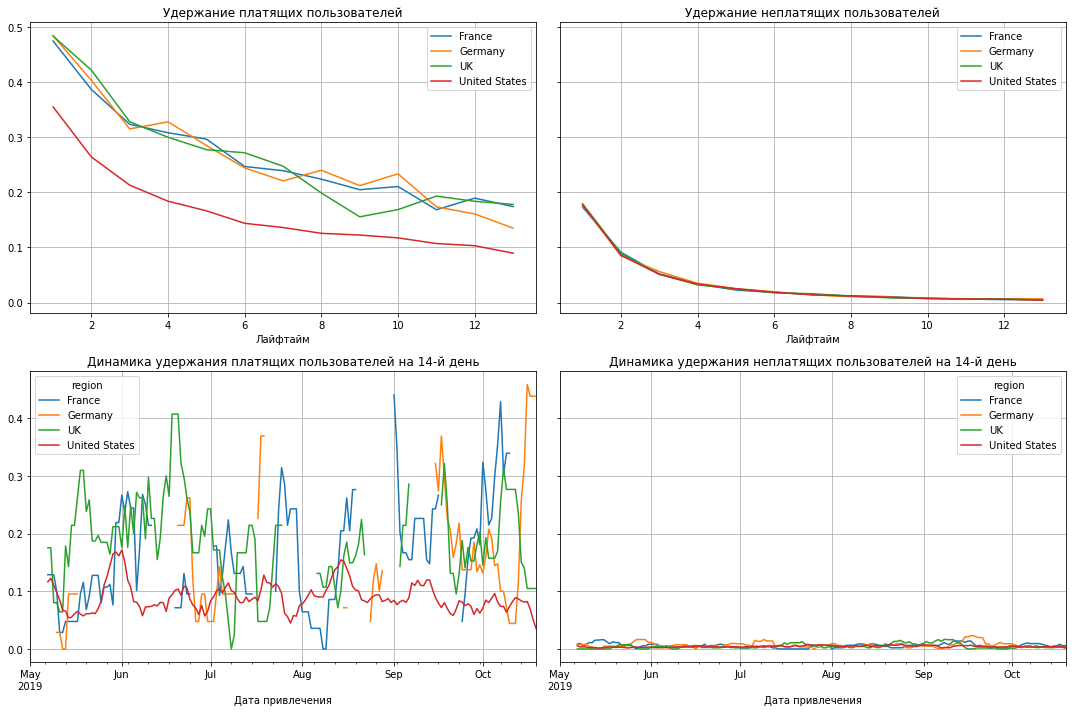

In [38]:
dimensions = ['region']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

В удержании пользователей США заметно проигрывает другим исследуемым регионам.<br>
Получается, высокая конверсия не приносит результат: пользователи скоро прощаются с приложением. 

**Конверсия и удержание с разбивкой по каналам привлечения**

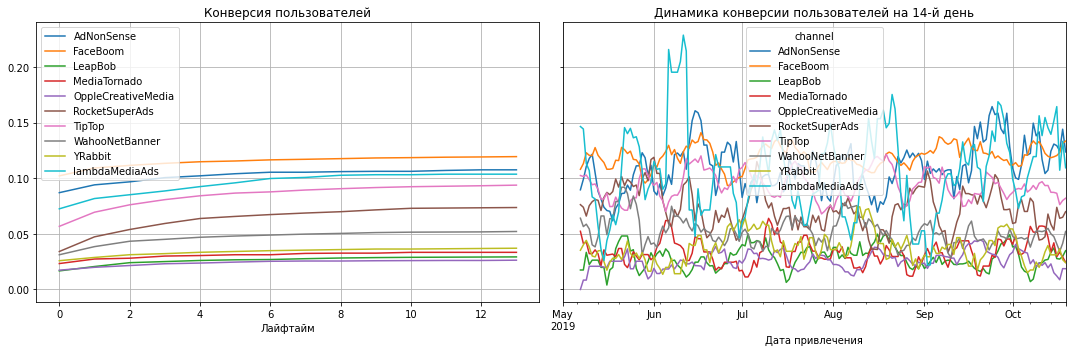

In [39]:
dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

В конверсии по каналам лидируют FaceBoom, AdNonSense и lambdaMediaAds, как и было ранее в нашей таблице по профилям пользователей.

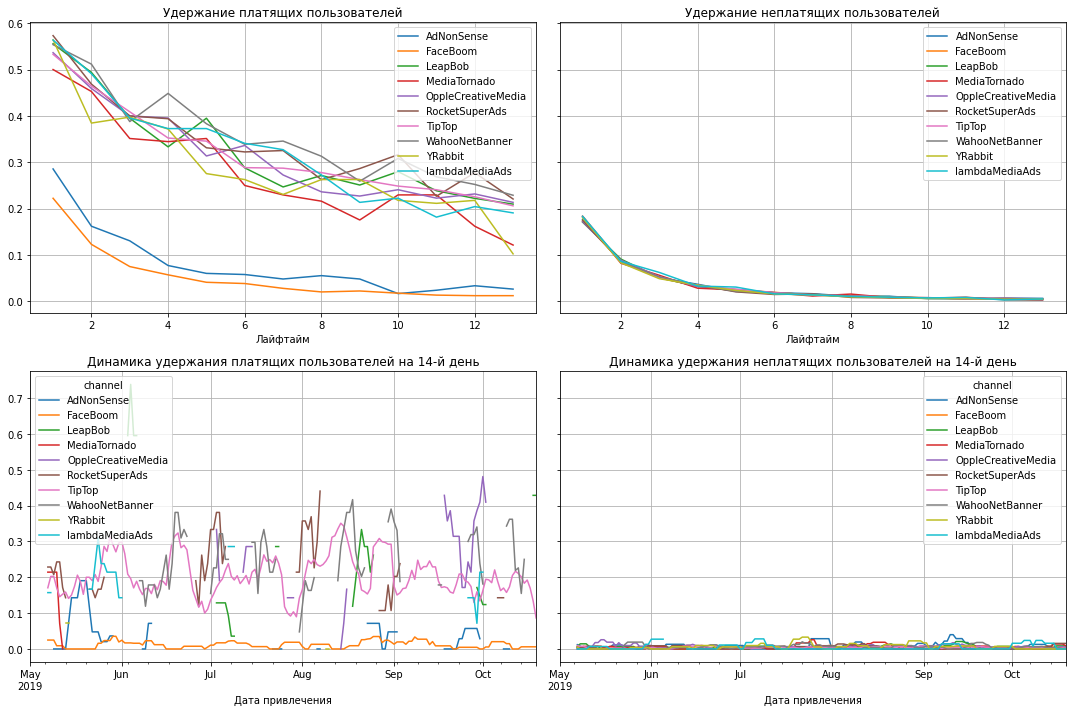

In [40]:
dimensions = ['channel']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

А вот удержание платящих пользователей из FaceBoom и AdNonSense - худшее, заметно ниже других каналов.

**Окупаемость рекламы с разбивкой по устройствам**<br>

Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

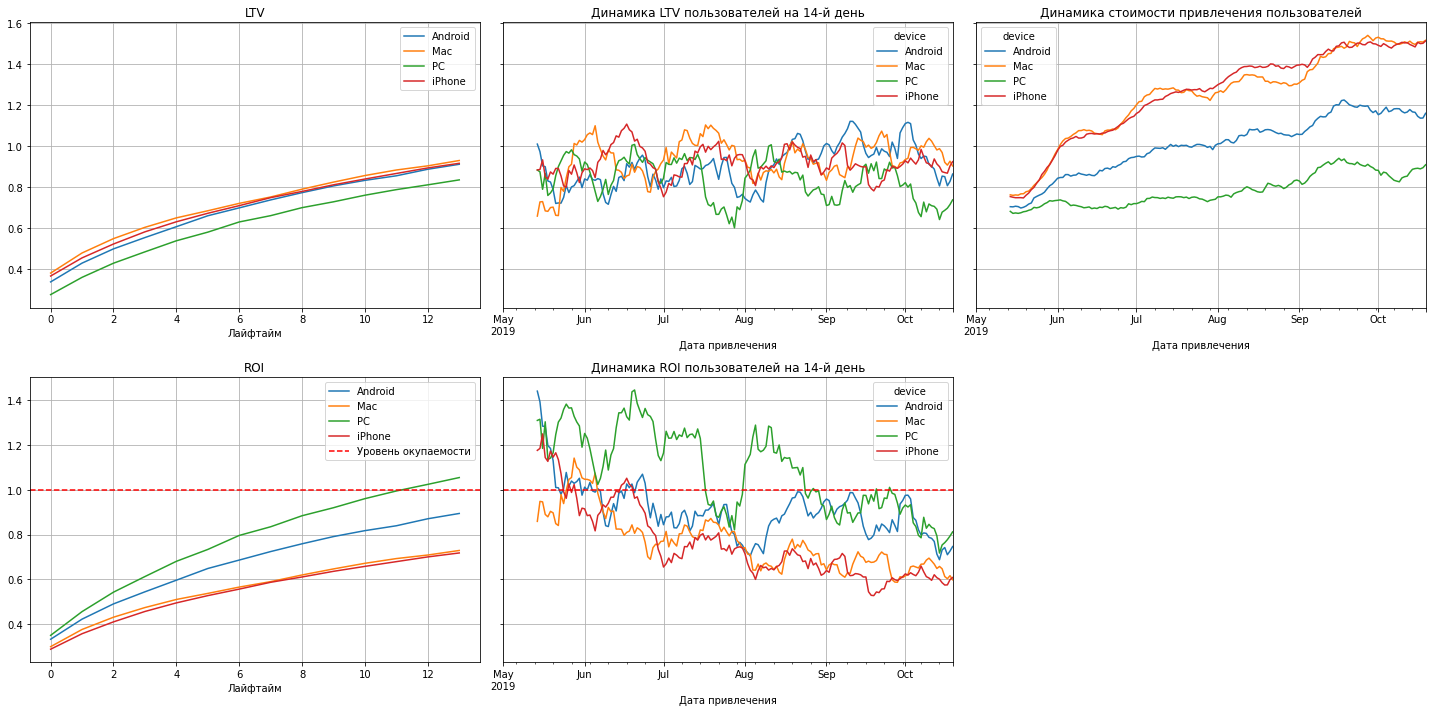

In [41]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

 - Для всех устройств растет стоимость привлечения, заметнее всего - Mac и iPhone.<br>
 - Также для всех устройств видно, что привлечение пользователей не окупается.<br>
 - Порог окупаемости еле-еле преодолели только пользователи PC.<br>

**Окупаемость рекламы с разбивкой по странам**

Снова обратимся к графикам LTV и ROI, а также графикам динамики LTV, CAC и ROI.

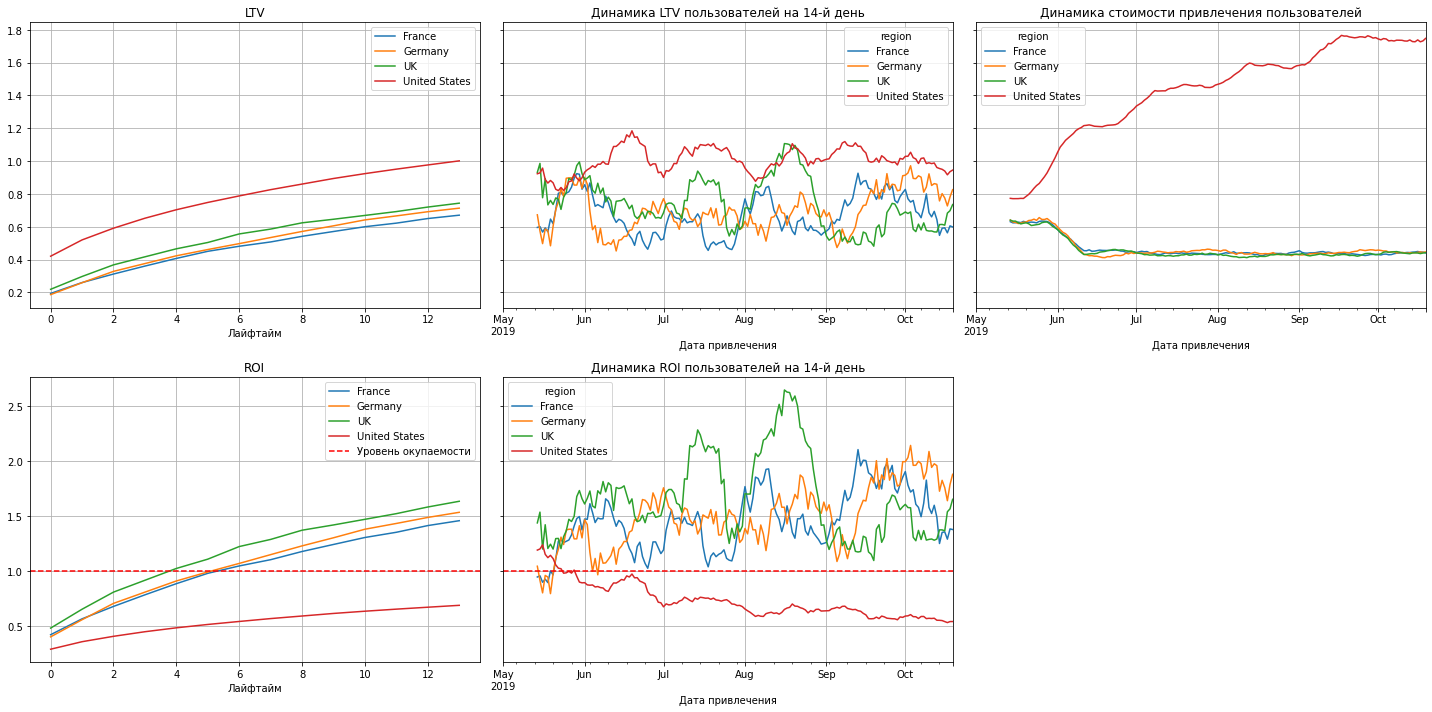

In [42]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

И вновь статистика США отличилась от других исследуемых стран.<br>
При наибольшем LTV у США наибольшие расходы на привлечение пользователей. Только у США окупаемость ниже 1.<br>

Похоже, мы приблизились к разгадке нашего расследования: более половины пользователей из США, но убытки от их привлечения постоянно растут.

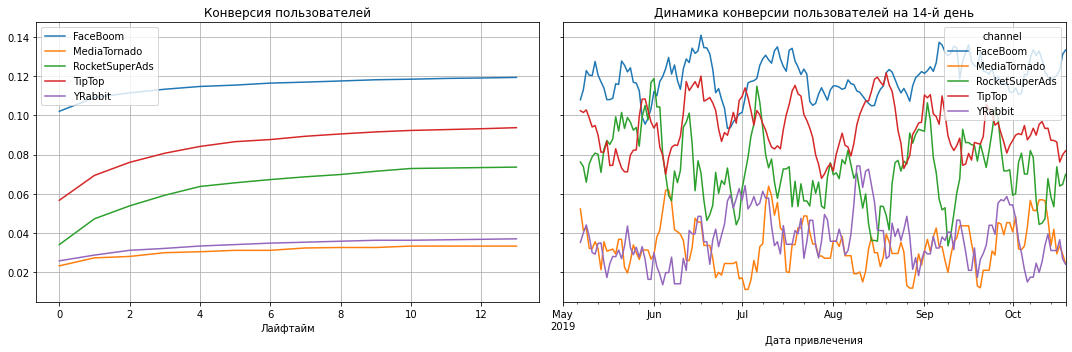

In [79]:
# Выделим профили пользователей США.
# Посмотрим конверсию с разбивкой по рекламным каналам:

profiles_usa = profiles.query('region == "United States"')

dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Лучшие показатели конверсии в США - у каналов FaceBoom, TipTop и RocketSuperAds.

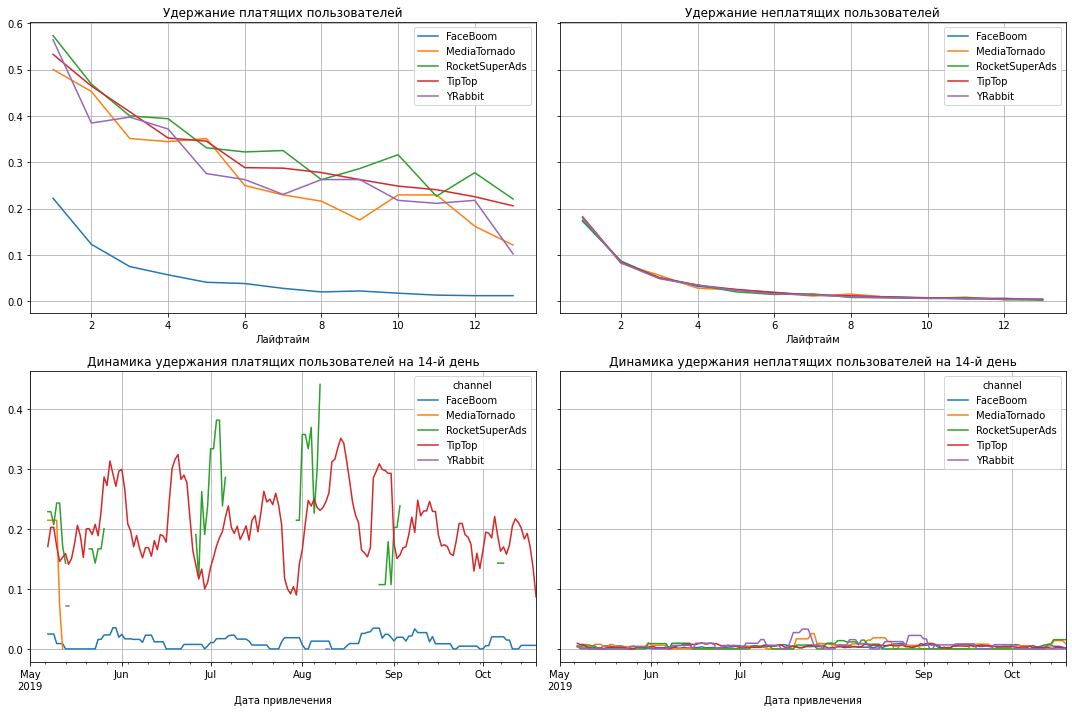

In [80]:
# Посмотрим удержание с разбивкой по рекламным каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_usa, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Худшее удержание платящих пользователей - через канал FaceBoom.<br>
Удержание через TipTop в среднем на общем уровне с другими каналами привлечения. 

Из отдельного обзора рынка США можно сказать, что стоит обратить внимание на канал RocketSuperAds.<br>
Не считая TipTop и FaceBoom, в RocketSuperAds лучший показатель конверсии в платящих пользователей среди остальных каналов США.

**Окупаемость рекламы с разбивкой по рекламным каналам**

Строим графики LTV и ROI и графики динамики LTV, CAC и ROI.

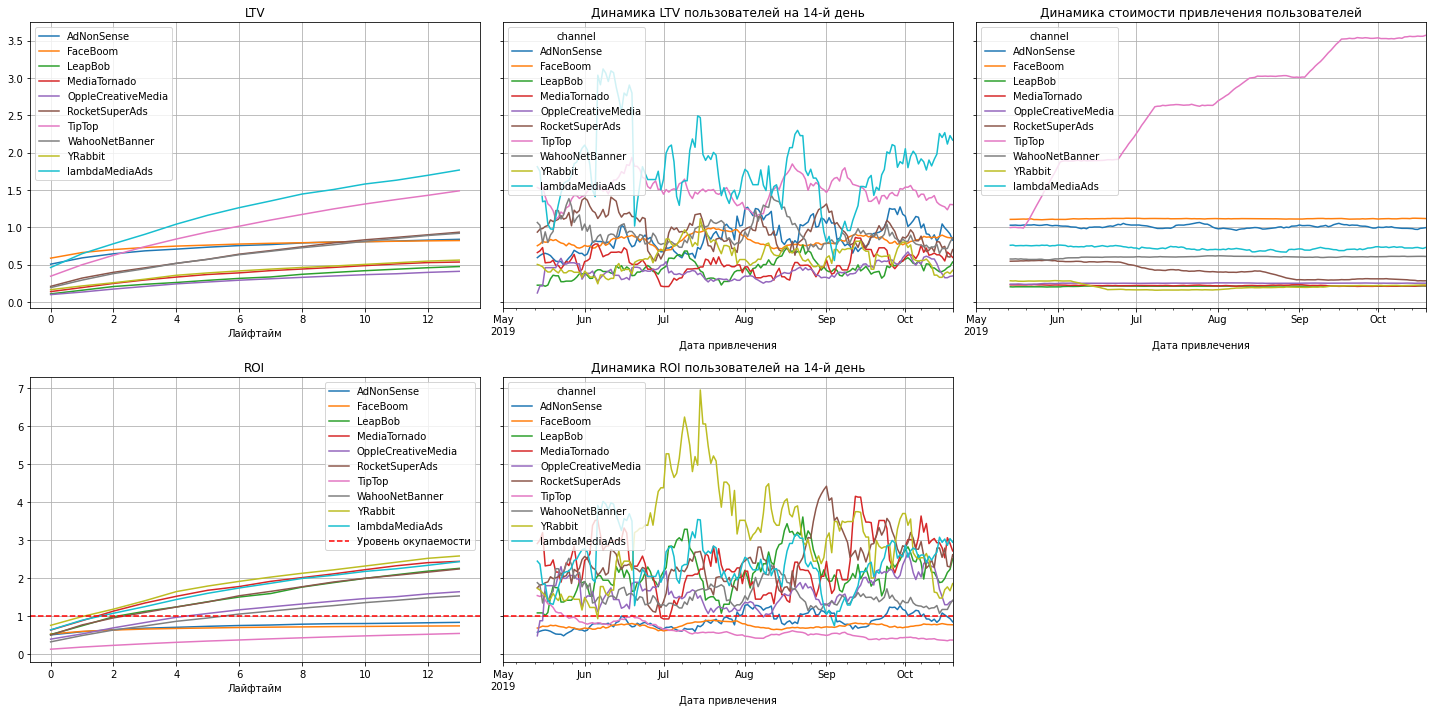

In [43]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
    
)

Следующая причина убытков нашего приложения кроется в каналах привлечения.<br>

 - Каналы-лидеры по продажам (FaceBoom, TipTop и AdNonSense) стабильно не окупаются из-за высокой стоимости привлечения.<br>

 - TipTop требует неестественно больших затрат на привлечение.

 - Напротив, канал lambdaMediaAds один из наиболее окупаемых: лучший LTV и один из лучших ROI.<br>
 Вспомним и то, что этот канал лидировал по конверсии, а по доле платящих пользователей - в тройке лидеров.<br>
 Средняя стоимость привлечения одного пользователя CAC у lambdaMediaAds не самая низкая, но заметно меньше, чем у FaceBoom, TipTop и AdNonSense.<br>
 При этом затраты на канал lambdaMediaAds в целом одни из самых низких.<br>
 
 Кажется, мы заметили "спасательный круг" в море неэффективных каналов.

**Итак, главные вопросы и ответы по окупаемости рекламы:**
  - Окупается ли реклама, направленная на привлечение пользователей в целом?<br>
  К концу второй недели реклама не окупается.
  <br>
  
  - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?<br>
    - Устройства: iPhone и Mac,
    - Страны - США,
    - Каналы: TipTop, FaceBoom, AdNonSense.<br>
    
- Чем могут быть вызваны проблемы окупаемости?<br>
   Расходом средств на неэффективные каналы привлечения, а также низким удержанием пользователей из США (а это большинство всех пользователей прложения).

### Общий вывод

**Мы проанализировали статистику использования проложения Procrastinate Pro+ и затраты на маркетинг за полгода:**<br> 

- Основной рынок приложения в США (66%), в остальных исследуемых странах Европы пользователей в разы меньше.<br>
Также, в США больше доля платящих пользователей: 7%, в остальных странах 4%.<br>


- Пользователи больше предпочитают мобильные устройства, в лидерах - iPhone.


- Общие расходы на привлечение пользователей составили почти 105 500 у.е.


- Самые дорогие каналы привлечения: TipTop и FaceBoom, суммарно более 80% всех расходов.<br>
При этом почти половина бюджета ушла на один источник - TipTop, и привлечённые из него покупатели обошлись дороже всего.


- За период исследования затраты на маркетинг через TipTop выросли в 6 раз.<br>
Также, в течение всего периода исследования, виден рост расходов только на каналы TipTop и FaceBoom, затраты на остальные можно назвать неизменными.<br>
 Уточним, что при расчете среднего мы не учитывали канал "organic", через который затраты на привлечение пользователей отсутствуют.


- Каналы-лидеры по продажам (FaceBoom, TipTop и AdNonSense) стабильно не окупаются из-за высокой стоимости привлечения.<br>
TipTop требует неестественно больших затрат на привлечение.


- Удержание платящих пользователей из FaceBoom и AdNonSense - худшее, заметно ниже других каналов.<br>
Низкое удержание можно объяснить тем, что аудитория, которую мы привлекаем с этих каналов - не целевая.<br>


**Рекомендации для отдела маркетинга:**<br>
- Пересмотреть работу с каналом TipTop, а именно - снижение затрат на работу через него (так как пользователи с этого канала демонстрируют высокий LTV, хорошие конверсию и удержание).<br>


- Стоит обратить внимание на каналы, окупаемость которых выше.<br>
  - *Рынок США*: канал RocketSuperAds.<br>
Не считая TipTop и FaceBoom, в RocketSuperAds лучший показатель конверсии в платящих пользователей среди остальных каналов США.<br>
Хорошее удержание и достойная доля платящих пользователей, а стоимость привлечения не слишком высока.
  - *Европейский рынок*: lambdaMediaAds, он из наиболее окупаемых: лучший LTV и один из лучших ROI.<br>
Кроме того, этот канал лидировал по конверсии, а по доле платящих пользователей - в тройке лидеров.<br>
Средняя стоимость привлечения одного пользователя CAC у lambdaMediaAds не самая низкая, но заметно меньше, чем у FaceBoom, TipTop и AdNonSense.<br>
При этом затраты на канал lambdaMediaAds в целом одни из самых низких.<br>


- Поработать над конверсией PC, так как пользователи персональных компьютеров тоже могут улучшить прибыльность:
  - Удержание платящих пользователей здесь лучше, чем на других устройствах,
  - Среди всех устройств только PC смог преодолеть порог окупаемости.